<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr10/Practice10_selfsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np 
import time
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats

from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# utils

In [ ]:
def make_mnist(batch_size = 256, transform=None, size=None):
    if transform is None:
        transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(0.5, 0.5), 
                                        transforms.Lambda(lambda x: torch.flatten(x))])
    traindata = MNIST(
                        root='./data',
                        train=True, 
                        transform=transform,
                        download=True
                     )
    testdata = MNIST(
                        root='./data',
                        train=False, 
                        transform=transform,
                        download=True
                    )

    if size:
        traindata.data = traindata.data[:size]
        traindata.targets = traindata.targets[:size]

    trainloader = DataLoader(
        dataset=traindata,
        batch_size=batch_size,
        shuffle=True
        )
    
    testloader = DataLoader(
        dataset=testdata,
        batch_size=batch_size,
        shuffle=False)
    
    return trainloader, testloader

In [ ]:
@torch.no_grad()
def show_reconstruction(encoder, decoder, dataloader, sig=0.1, blur=None):
    x, _ = iter(dataloader).next()
    x = x[:10]
    if sig:
        x = x + torch.randn_like(x) * sig
    if blur:
        x = transforms.GaussianBlur(blur)(x).reshape(10, -1)
    x = torch.clip(x, -1, 1)

    x_rec = decoder(encoder(x.float().to(device))).cpu()

    x = x.reshape(-1, 28, 28)
    x_rec = x_rec.reshape(-1, 28, 28)

    img = torch.cat((x, x_rec))
    img = img.unsqueeze(1)
    img = make_grid(img, nrow=10)
    img = tensor_to_image(img)
    img = img.clip(0, 1)

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
def tensor_to_image(x):
    x = x.detach().cpu().numpy()
    x = x.transpose(1, 2, 0)
    x = (x + 1) / 2
    return x

In [ ]:
def plot_training_plot(losses, title='Losses'):
    plt.figure()
    x = np.arange(len(losses))

    plt.plot(x, losses, label='loss')

    plt.legend()
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
@torch.no_grad()
def show_samples(model, sig=0.1, k=10):
    z = sig * torch.randn((10, 128)).to(device)
    dec = [model.dec(z)]

    for i in range(k-1):
        dec.append(model.dec(model.enc(dec[-1])))

    img = torch.cat(dec, dim=0).cpu()

    img = img.view(-1, 1, 28, 28)
    img = make_grid(img, nrow=k)
    img = tensor_to_image(img)
    img = img.clip(0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
@torch.no_grad()
def closest(model, k=500):
    transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5),
                                transforms.RandomCrop((10, 10))])
    
    trainloader, _ = make_mnist(k, transform, size=k)

    b, _ = next(iter(trainloader))

    b_enc = model.enc(b.float().to(device)).cpu().detach().numpy()

    dist = cosine_similarity(b_enc)

    closest = np.argsort(-dist, axis=1)[:, :10]
    closest = b[closest[:10].flatten()].reshape((100, 1, 10, 10))
    img = make_grid(closest, nrow=10)
    img = tensor_to_image(img)
    img = img.clip(0, 1)

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example 1. Denoising Autoencoder

In [ ]:
trainloader, _ = make_mnist()

In [ ]:
class DenoisingAE(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(784, 256), 
                                 nn.ReLU(), 
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, ld),
                                 nn.Sigmoid())

        self.dec = nn.Sequential(nn.Linear(ld, 128), 
                                 nn.ReLU(), 
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 784), 
                                 nn.Tanh())

    def loss(self, batch, sig):
        noise_batch = batch + torch.randn_like(batch) * sig
        noise_batch = torch.clip(noise_batch, -1, 1)
        z = self.enc(noise_batch)
        dec_batch = self.dec(z)
        loss = F.mse_loss(dec_batch, batch)
        # reg_loss = 0.1 * (z ** 2).sum(dim=-1).mean()

        return loss #+ reg_loss
    
    def fit(self, dataloader, num_epochs=100, lr=1e-3, sig=0.1):

        losses = []
        optim = opt.Adam(self.parameters(), lr=lr)

        for epoch in tqdm(range(num_epochs)):
            for (batch, _) in dataloader:
                batch = batch.float().to(device)
                loss = self.loss(batch, sig)
                optim.zero_grad()
                loss.backward()
                optim.step()
                losses.append(loss)
        return losses

In [ ]:
model = DenoisingAE(128).to(device)

  0%|          | 0/10 [00:00<?, ?it/s]

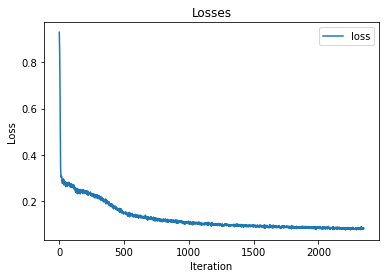

In [ ]:
losses = model.fit(trainloader, num_epochs=10, sig=1)
plot_training_plot(losses)

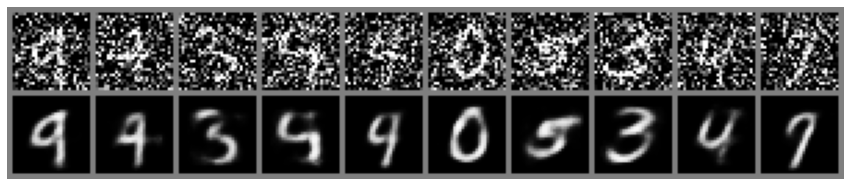

In [ ]:
show_reconstruction(model.enc, model.dec, trainloader, sig=1.2)

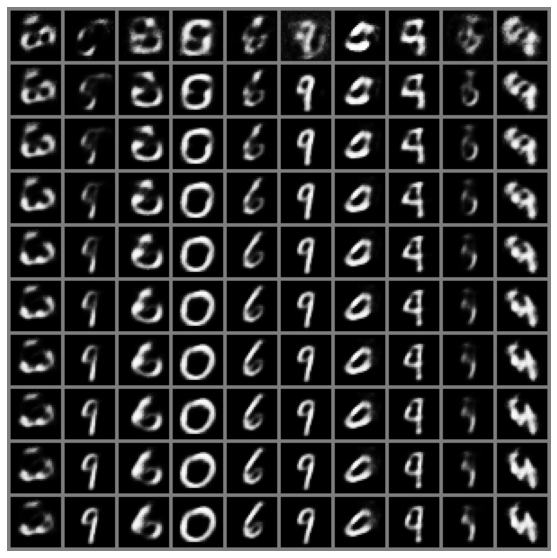

In [ ]:
show_samples(model, sig=1, k=10)

In [ ]:
model2 = DenoisingAE(128).to(device)

  0%|          | 0/10 [00:00<?, ?it/s]

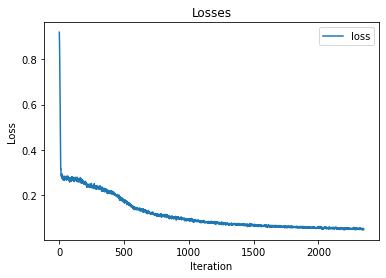

In [ ]:
losses = model2.fit(trainloader, num_epochs=10, sig=0)
plot_training_plot(losses)

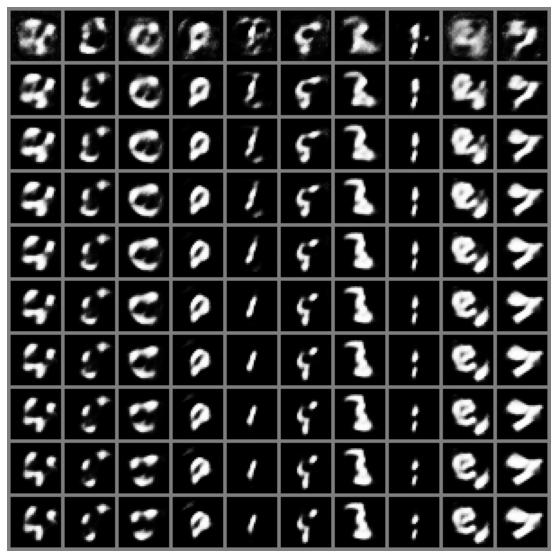

In [ ]:
show_samples(model2, sig=1, k=10)

# Example 2. Relative Position Prediction

In [ ]:
class Encoder(nn.Module):
    def __init__(self, ld=16):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), 
                                   nn.ReLU(),
                                   nn.Conv2d(32, 64, 3, 2, 1),
                                   nn.ReLU(), 
                                   nn.Conv2d(64, 128, 3, 2, 1), 
                                   nn.ReLU(), 
                                   nn.Conv2d(128, 128, 3, 2, 1), 
                                   nn.Flatten())
        
        self.tail = nn.Sequential(nn.Linear(128 * 4, 128), 
                                  nn.ReLU(),
                                  nn.Linear(128, ld))

    def forward(self, x):
        return self.tail(self.model(x))

    def encode(self, x):
        return self.model(x)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, ld=16):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(ld * 2, 64), 
                                   nn.ReLU(), 
                                   nn.Linear(64, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 1), 
                                   nn.Sigmoid())
                
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class LeftRightClf(nn.Module):
    def __init__(self, ld=128):
        super().__init__()
        self.enc = Encoder(ld)
        self.clf = Classifier(ld)

    
    def loss(self, batch):
        batch = batch.float().to(device)
        bs = len(batch)
        l, r = torch.chunk(batch, 2, dim=2)
        l_enc, r_enc = self.enc(l), self.enc(r)


        top = torch.cat((l_enc[:bs//2], r_enc[:bs//2]), dim=1)
        bottom = torch.cat((r_enc[bs//2:], l_enc[bs//2:]), dim=1)
        all = torch.vstack((top, bottom))

        preds = self.clf(all)

        labels = torch.cat((torch.ones(len(top)), torch.zeros(len(bottom)))).unsqueeze(1).to(device)

        loss = F.binary_cross_entropy(preds, labels)

        return loss, preds, labels
    
   
    
    def fit(self, trainloader, num_epochs=10, lr=1e-3):

        losses = []
        aucs = []
        optim = opt.Adam(self.parameters(), lr=lr)
 
        for epoch in tqdm(range(num_epochs)):
            all_preds = []
            all_labels = []

            for (batch, _) in trainloader:
                loss, preds, labels = self.loss(batch)
                # print(loss)
                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss)

                all_preds = all_preds + preds.detach().cpu().tolist()
                all_labels = all_labels + labels.detach().cpu().tolist()
            aucs.append(auc(all_labels, all_preds))
        return losses, aucs

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5),
                                transforms.RandomCrop((20, 10))])

trainloader, _ = make_mnist(256, transform)

In [ ]:
model = LeftRightClf(128).to(device)
losses = model.fit(trainloader, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

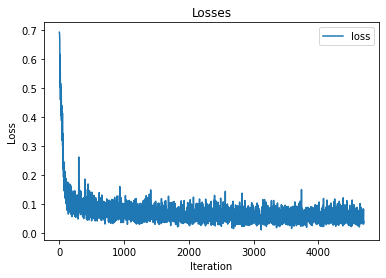

In [ ]:
plot_training_plot(losses[0])

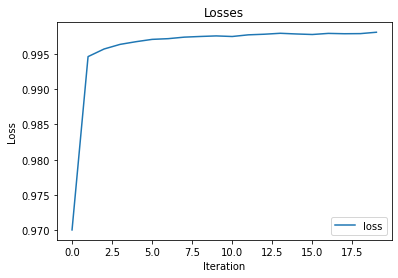

In [ ]:
plot_training_plot(losses[1])

In [ ]:
torch.save(model.state_dict(), 'lr.pcl')

### nearest neigbours

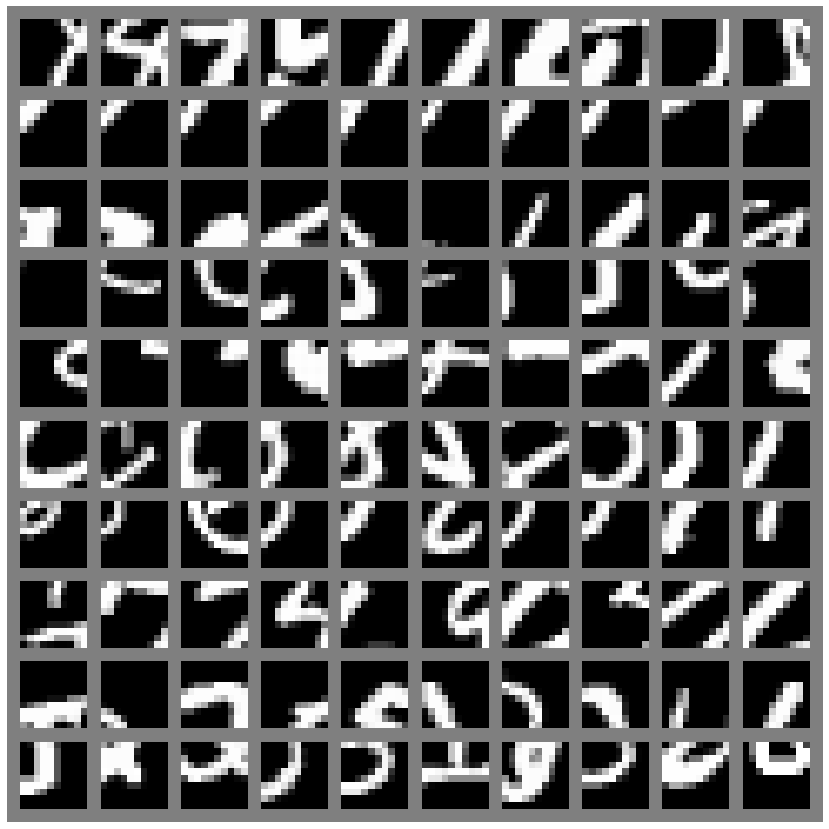

In [ ]:
closest(model, k=1000)

# Example 3. Jitter

In [ ]:
class LeftRightJitterClf(LeftRightClf):
    def __init__(self, ld=128):
        super().__init__(ld)
        self.trans = transforms.RandomCrop((10, 10))

    
    def loss(self, batch):
        batch = batch.float().to(device)
        bs = len(batch)
        l, r = torch.chunk(batch, 2, dim=2)

        l = self.trans(l)
        r = self.trans(r)

        l_enc, r_enc = self.enc(l), self.enc(r)


        top = torch.cat((l_enc[:bs//2], r_enc[:bs//2]), dim=1)
        bottom = torch.cat((r_enc[bs//2:], l_enc[bs//2:]), dim=1)
        all = torch.vstack((top, bottom))

        preds = self.clf(all)

        labels = torch.cat((torch.ones(len(top)), torch.zeros(len(bottom)))).unsqueeze(1).to(device)

        # loss = preds[:bs//2].mean() - preds[bs//2:].mean()
        loss = F.binary_cross_entropy(preds, labels)

        return loss, preds, labels

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5),
                                transforms.RandomCrop((26, 13))])

trainloader, _ = make_mnist(256, transform)

In [ ]:
model2 = LeftRightJitterClf(128).to(device)
losses = model2.fit(trainloader, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

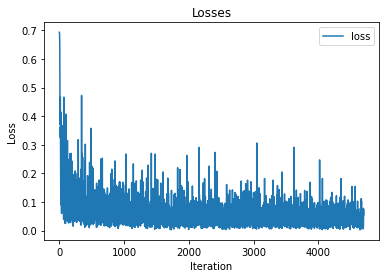

In [ ]:
plot_training_plot(losses[0])

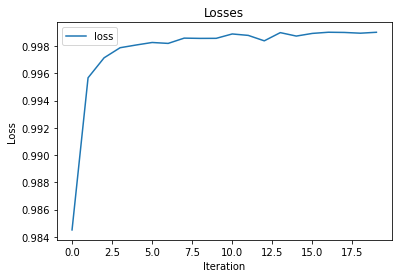

In [ ]:
plot_training_plot(losses[1])

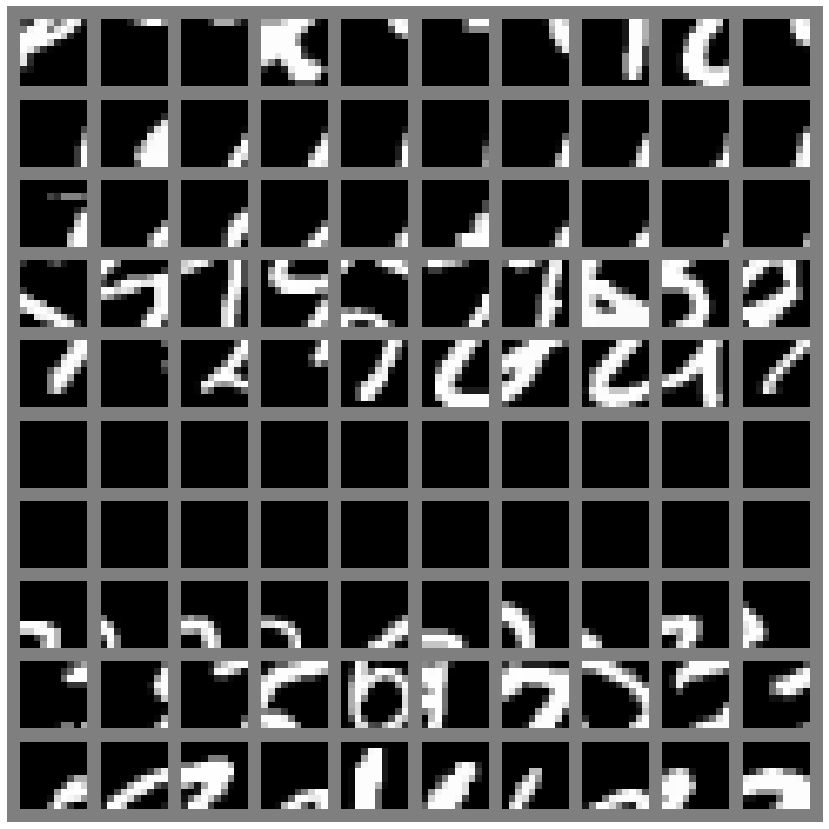

In [ ]:
closest(model2, k=1000)

## Chromatic Aberration

Chromatic aberration occurs when the different focal lengths of light results in the light not meeting all at the same point. 
![from wikipedia](https://drive.google.com/uc?id=1PYGoQWnH0aAeiE_8t4ef5WDcq1UIQQ5t)

A example of very apparent chromatic aberration is shown below, where the green and magenta colors are clearly offset with each other:

![](https://drive.google.com/uc?id=1M1B6kV6ddBwyJse3FQT8_XBTeqs5s5WL)

Chromatic aberration generally becomes a problem in patch-based self-supervised learning tasks that design, such as solving jigsaw puzzles, or predicintg the correct location of a patch in an image In this case, the model can take advantage of the low-level chromatic aberration features to get a strong idea of where the patch is located without understanding the actual context.

Below is a quick demo of chromatic aberration in more realistic images, and possible fixes. Note that in general, chromatic aberration is fairly hard to spot with the naked eye, but deep learning models are still able to use it to their advantage.

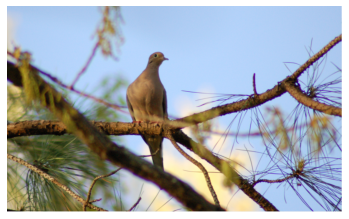

Chromatic aberration is generally fixed through conversion to grayscale, or color dropping. Color dropping works by dropping 2 of the color channels and replacing them with random noise uniform or Gaussian noise.

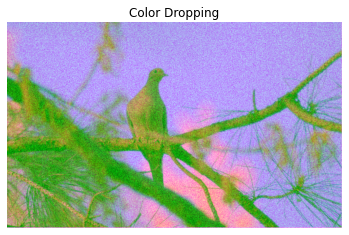

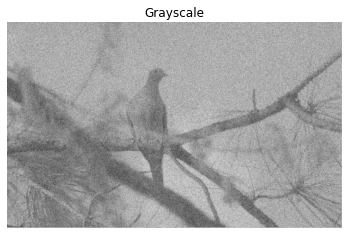